In [182]:
library(tidyverse)
options(repr.plot.height=6, repr.plot.width=10)
theme_set(theme_classic())

# STATS 604 
## Week 5: Solar weather and GOES data

https://www.youtube.com/watch?v=oOXVZo7KikE

## About the data source
- The Geostationary Operational Environmental Satellites (GOES) are a series of satellites in geostationary orbit.
- They collect:
    - [Terrestrial weather data](https://www.star.nesdis.noaa.gov/goes/) (cloud cover, storms, hurricanes, etc.)
    - Atmospheric observations (temperature, humidity, solar radiation)
    - [Space weather data](https://www.swpc.noaa.gov/products/goes-x-ray-flux) (our focus)

## Space weather
https://www.youtube.com/watch?v=oOXVZo7KikE

## The raw data
(Importing in R turned out to be difficult so I switched over to Python)

In [2]:
goes_2018_01 <- read_csv("goes_2018_01.csv.gz")

New names:
• `` -> `...1`
Rows: 2609428 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Sat
dbl (7): ...1, Year, Month, Day, Time, Flux1, Flux2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Plotting the raw data
To start with, how can we visualize our data? (It is very large/dense.) We will start by assigning an "absolute time" to each observation:


In [107]:
library(lubridate)
goes_2018_01 %>% 
    mutate(t0 = as.numeric(make_datetime(Year, Month, Day, 0, 0, 0)),
           t = t0 + Time,
           Time = as.POSIXct(t, origin="1970-01-01", tz="UTC")) -> df_wide


df_wide %>% pivot_longer(Flux1:Flux2) -> df

df

...1,Year,Month,Day,Time,Sat,t0,t,name,value
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
0,2018,1,1,2017-12-31 23:59:58,go14,1514764800,1514764799,Flux1,3.7050e-08
0,2018,1,1,2017-12-31 23:59:58,go14,1514764800,1514764799,Flux2,1.1784e-08
1,2018,1,1,2018-01-01 00:00:01,go14,1514764800,1514764801,Flux1,3.7050e-08
1,2018,1,1,2018-01-01 00:00:01,go14,1514764800,1514764801,Flux2,1.1205e-08
2,2018,1,1,2018-01-01 00:00:03,go14,1514764800,1514764803,Flux1,3.7050e-08
2,2018,1,1,2018-01-01 00:00:03,go14,1514764800,1514764803,Flux2,1.2940e-08
3,2018,1,1,2018-01-01 00:00:05,go14,1514764800,1514764805,Flux1,3.1917e-08
3,2018,1,1,2018-01-01 00:00:05,go14,1514764800,1514764805,Flux2,1.3519e-08
4,2018,1,1,2018-01-01 00:00:07,go14,1514764800,1514764807,Flux1,2.9351e-08


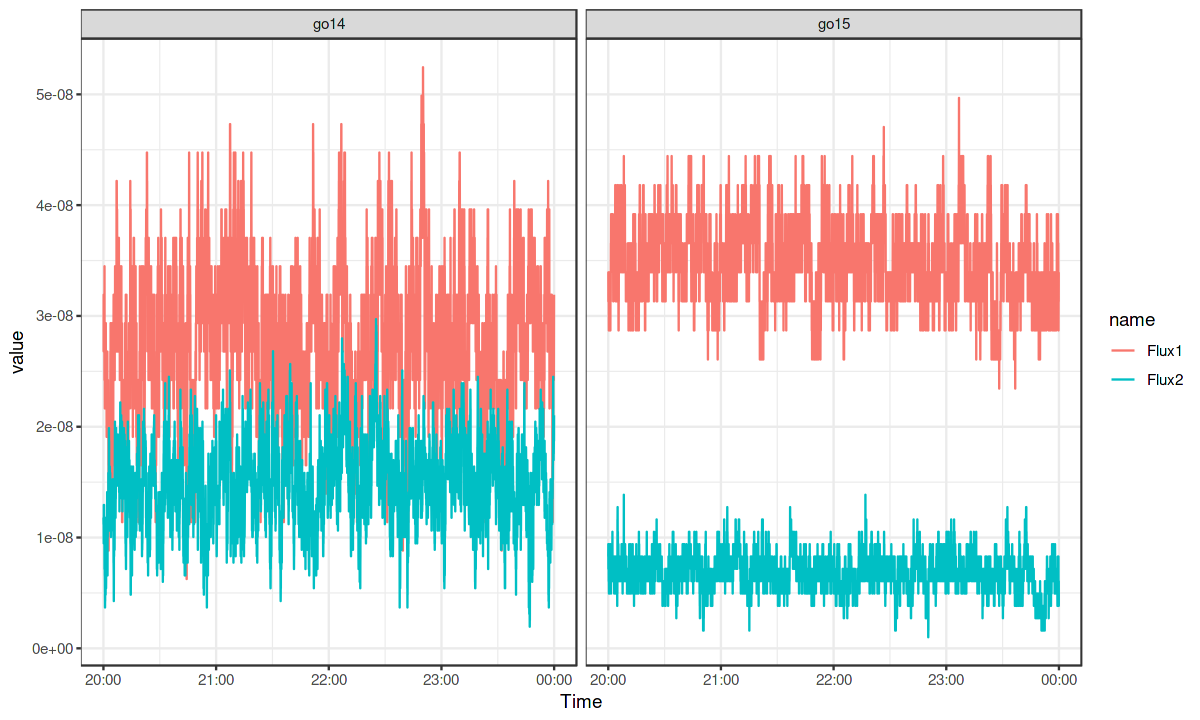

In [129]:
df %>% filter(Day == 1, Time >= make_datetime(2018, 1 , 1, 20, 00),
             Time <= make_datetime(2018, 1 , 1, 24, 00)) %>% 
    ggplot() + 
    geom_line(aes(x = Time, y = value, color = name)) + 
    facet_grid(~ Sat) 

## What is the relationship between Flux1 and Flux2?



Call:
lm(formula = Flux2 ~ Flux1, data = df_wide)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.568e-08 -7.320e-09 -1.940e-09  6.910e-09  1.727e-06 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.142e-08  8.433e-12    1354   <2e-16 ***
Flux1       5.782e-02  2.036e-04     284   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.228e-09 on 2609426 degrees of freedom
Multiple R-squared:  0.02998,	Adjusted R-squared:  0.02998 
F-statistic: 8.065e+04 on 1 and 2609426 DF,  p-value: < 2.2e-16


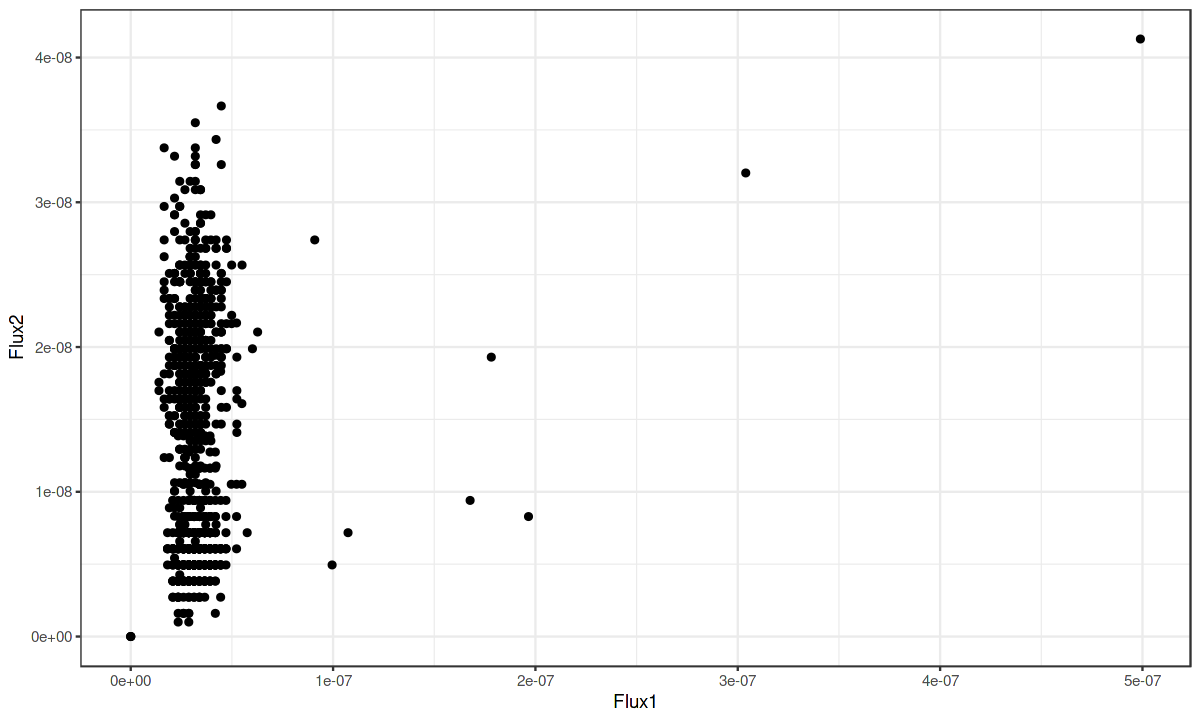

In [127]:
df_wide %>% sample_n(1000) %>% ggplot + geom_point(aes(x=Flux1, y=Flux2)) 

lm(Flux2 ~ Flux1, data = df_wide) %>% summary

There is too much noise so we need to use averaging to try and get a sense of the underlying signal:

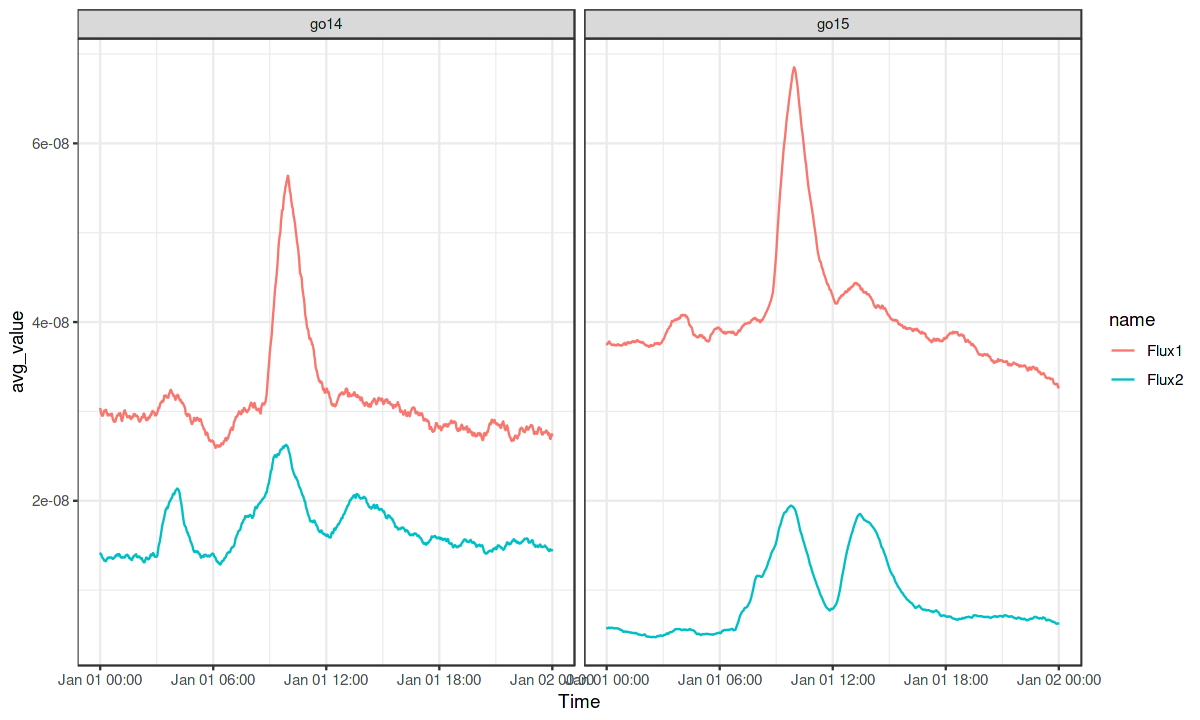

In [138]:
library(slider)
df %>% filter(Day == 1) %>% 
    arrange(Sat, name, t) %>% 
    group_by(name, Sat) %>% 
    mutate(avg_value = slide_dbl(value, mean, .before=1000, .after=1000)) %>% 
    ggplot + geom_line(aes(x=Time, y=avg_value, color=name)) + facet_grid(~ Sat)

## Daily averages
To get a very "high" level picture of the data, we can do the usual thing and summarize by each day:

`summarise()` has grouped output by 'Day'. You can override using the `.groups` argument.


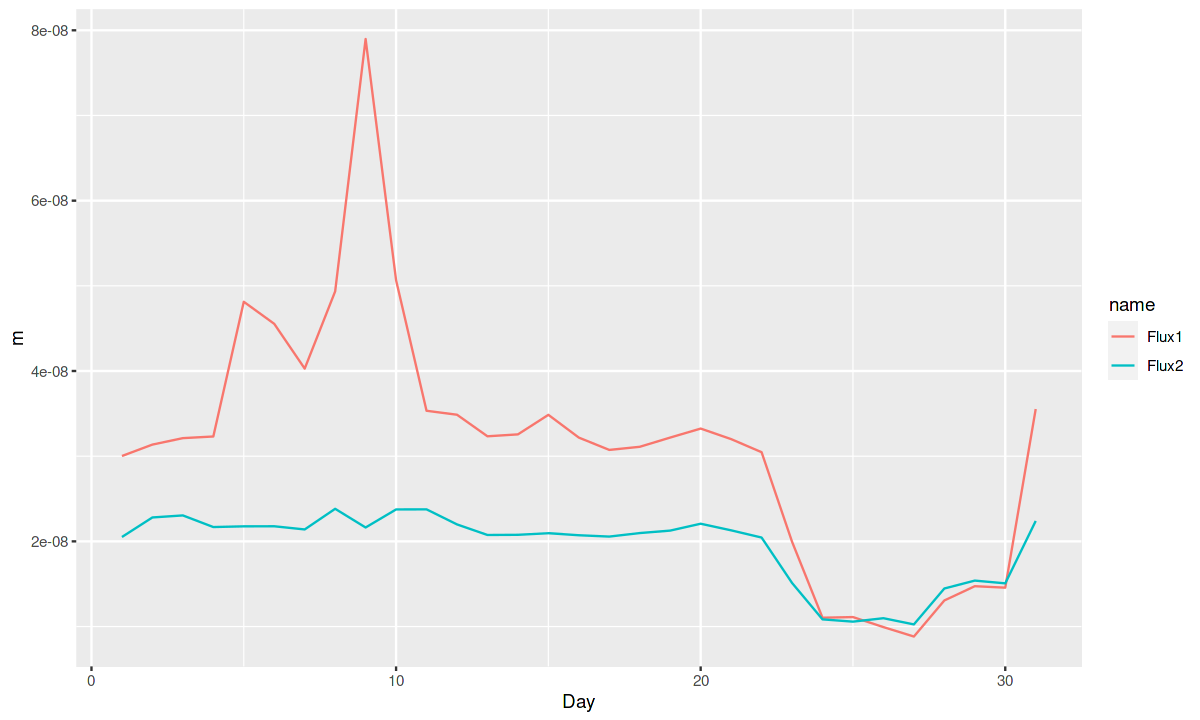

In [64]:
df %>% group_by(Day, name) %>% summarize(m=mean(value)) %>% 
    ggplot + geom_line(aes(x=Day, y=m , color=name))

## Correlations
How correlated are the two measurements?

Warning message:
“Values from `value` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(...1, Year, Month, Day, Time, t0, t, name) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(Flux1, Flux2)`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1594 rows containing non-finite values (`stat_density2d()`).”


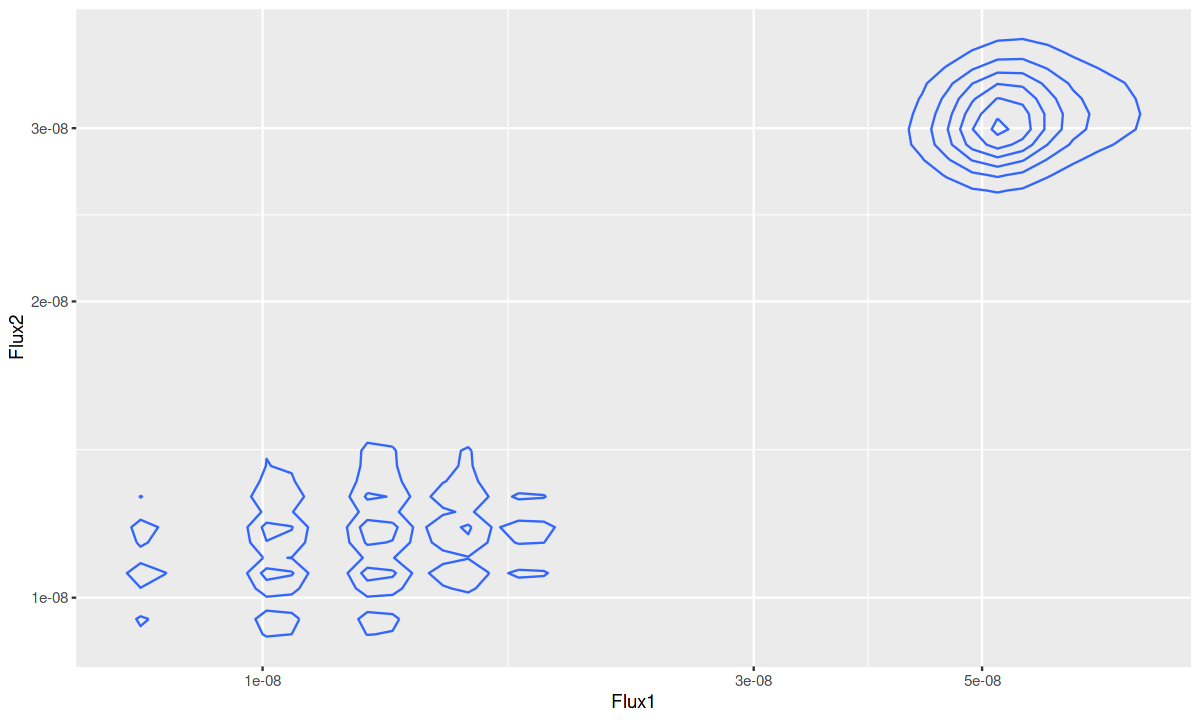

In [83]:
df %>% pivot_wider(values_from=value, names_from=name) %>% unnest %>% 
    ggplot + geom_density_2d(aes(x=Flux1, y=Flux2)) + scale_x_log10() + 
    scale_y_log10()

## What is the distribution of Flux? 
- What is the marginal distribution of Flux?
- Are the distributions of Flux1 and Flux2 the same or different?

Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 11962 rows containing non-finite values (`stat_bin()`).”


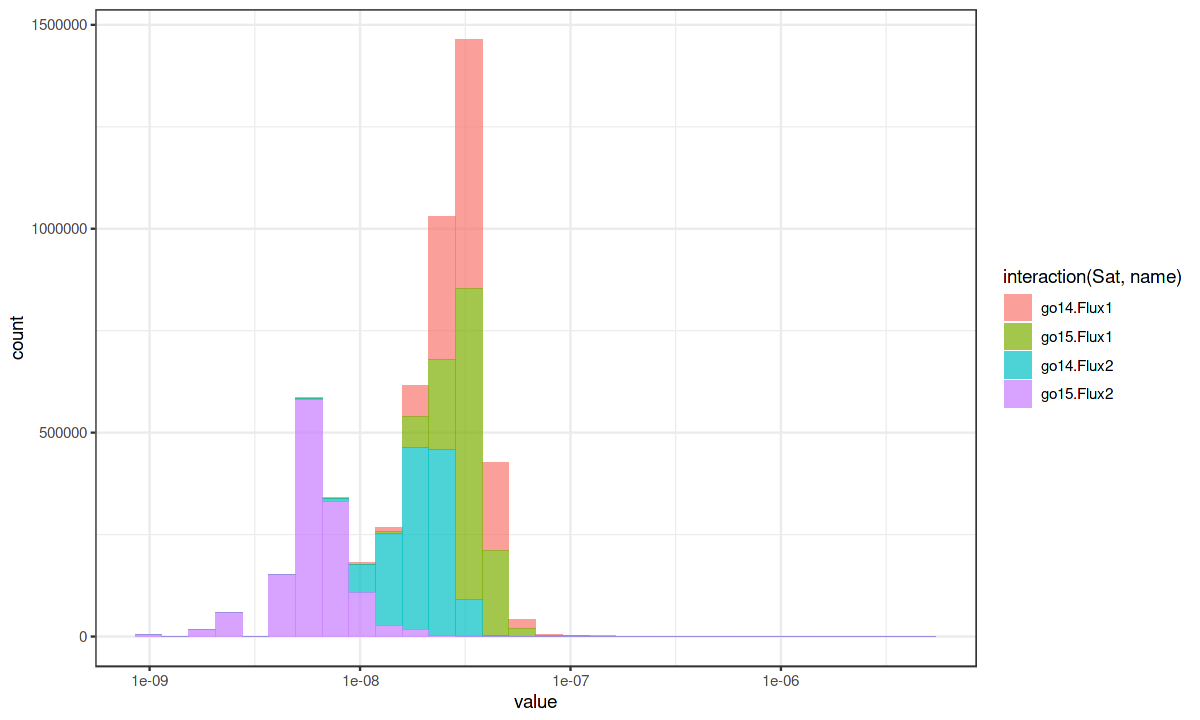

In [152]:
df %>% ggplot() + geom_histogram(aes(x=value, fill=interaction(Sat, name)), alpha=.7) + scale_x_log10()

## Is it $AR(k)$?

In [90]:
df %>% arrange(name, t) %>% group_by(name) %>% mutate(dv = c(NaN, diff(value))) %>% head
    ggplot + geom_histogram(aes(x = dv, fill = name), bins=100)

...1,Year,Month,Day,Time,t0,t,name,value,dv
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<int>,<dbl>,<chr>,<dbl>,<dbl>
0,2018,12,1,2018-11-30 23:59:59,1543622400,1543622399,Flux1,4.9881e-08,NaN
0,2018,12,1,2018-11-30 23:59:59,1543622400,1543622400,Flux1,1.0329e-08,-3.95520e-08
1,2018,12,1,2018-12-01 00:00:01,1543622400,1543622401,Flux1,4.9881e-08,3.95520e-08
1,2018,12,1,2018-12-01 00:00:01,1543622400,1543622402,Flux1,7.7058e-09,-4.21752e-08
2,2018,12,1,2018-12-01 00:00:03,1543622400,1543622403,Flux1,4.9881e-08,4.21752e-08
2,2018,12,1,2018-12-01 00:00:03,1543622400,1543622404,Flux1,1.0329e-08,-3.95520e-08


NULL

## Perodicity in the data
One question we have looking at these plots is whether/to what extent the data are "periodic". To measure this we can look at a "periodogram":

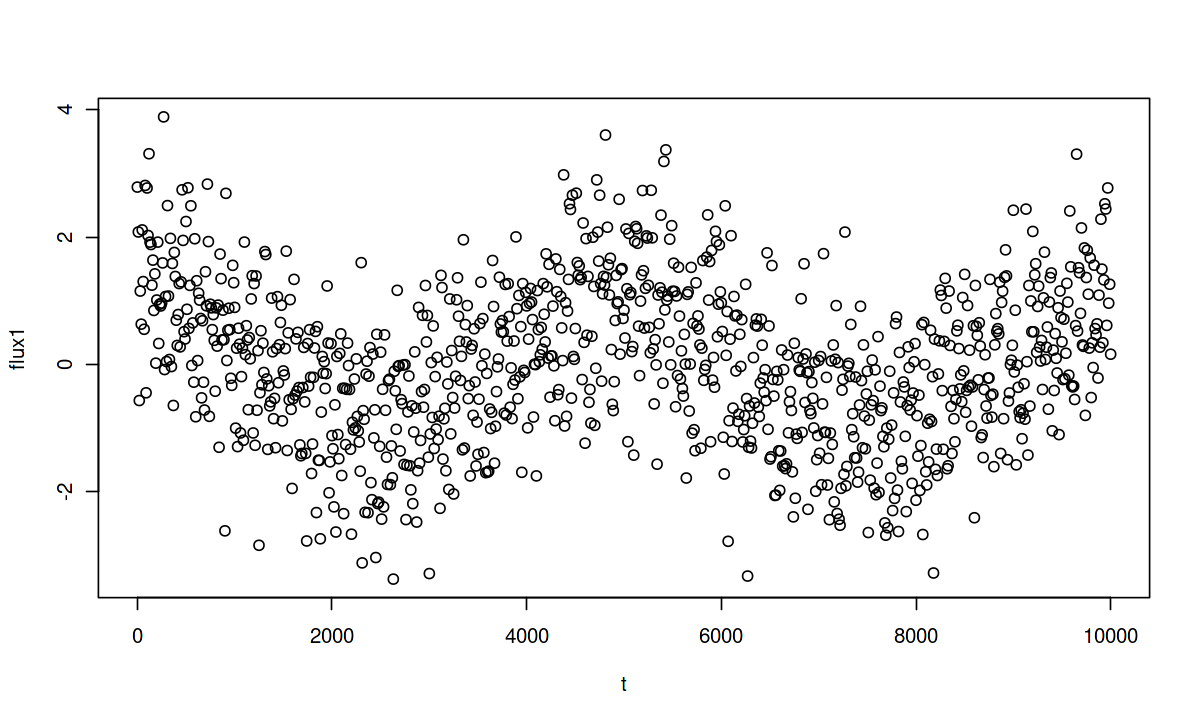

In [359]:
period = 5000
w = 1 / period
t <- seq(0, 10000, 10)
flux1 = cos(w*2*pi*t) + rnorm(n=length(t))
plot(t, flux1)

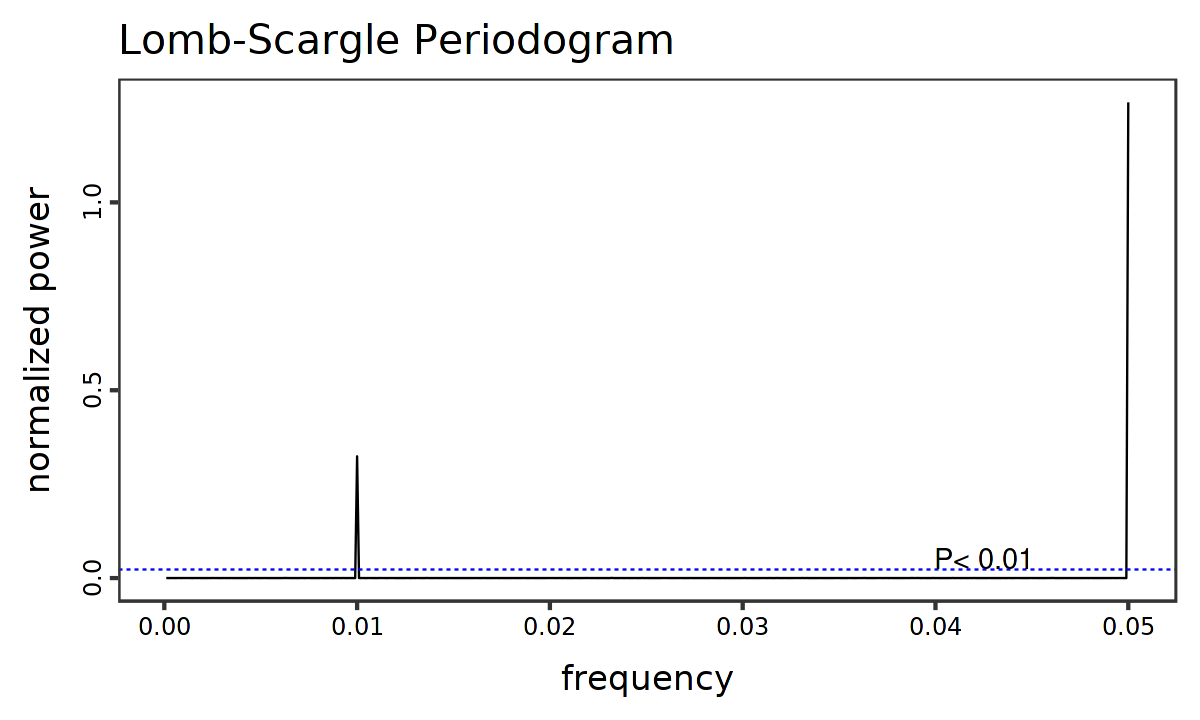

In [363]:
# install.packages("lomb")
library(lomb)

period = 100
w = 1 / period
t <- seq(0, 10000, 10)
flux1 = cos(w*2*pi*t) + cos(5*w*2*pi*t) + 0.2*rnorm(n=length(t))
lsp(flux1, t)

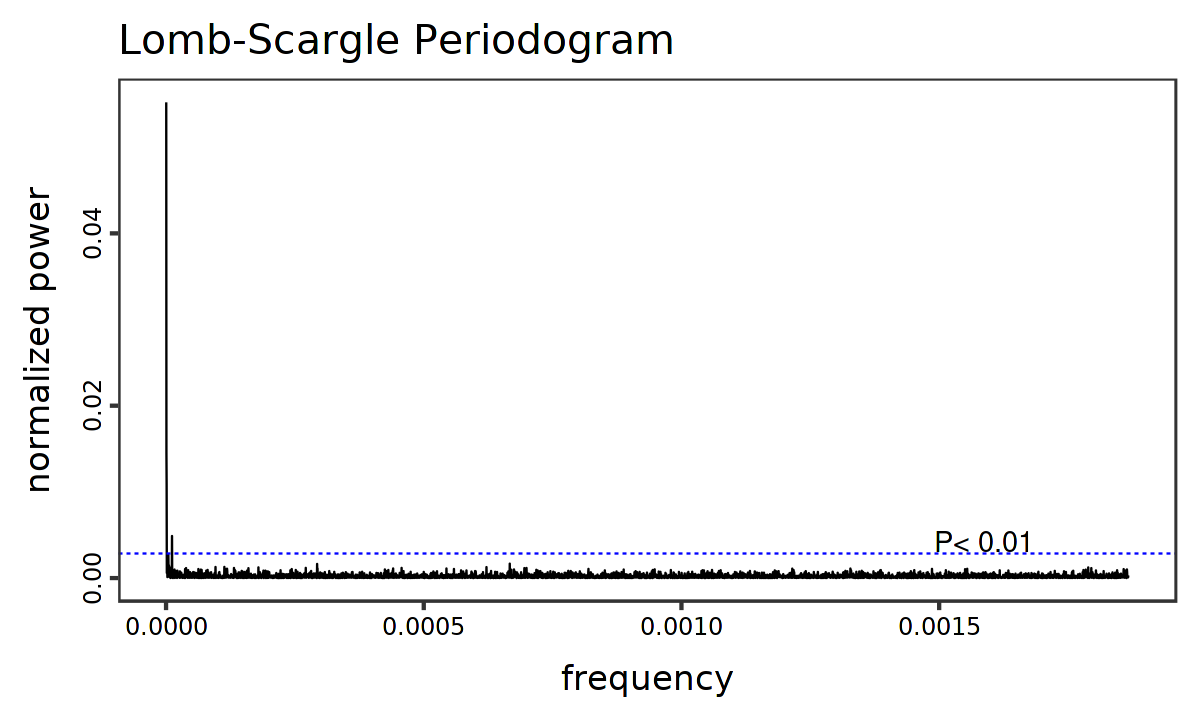

In [53]:
df_small <- sample_n(df, 10000)
lsp(df_small$Flux2, df_small$t)

## Daily averaged GOES data
Now we will take a step (way) back and look at long-term X-Ray data. To prepare this data, I downloaded every observation from 2005-2020, and then took a daily average.

In [412]:
library(arrow)
goes_daily <- arrow::read_feather("goes_daily.feather") %>% str

tibble [8,825 × 6] (S3: tbl_df/tbl/data.frame)
 $ year : int [1:8825] 2005 2005 2005 2005 2005 2005 2005 2005 2005 2005 ...
 $ month: int [1:8825] 1 1 1 1 1 1 1 1 1 1 ...
 $ day  : int [1:8825] 1 2 3 4 5 6 7 8 9 10 ...
 $ sat  : Factor w/ 6 levels "go10","go11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ flux1: num [1:8825] 2.35e-06 4.11e-07 3.98e-07 3.74e-07 1.27e-07 ...
 $ flux2: num [1:8825] 4.78e-07 2.20e-08 2.18e-08 2.66e-08 1.19e-08 ...


In [320]:
# save(goes_daily, file="goes_daily.RData")

load(url('https://github.com/terhorst/stats504/raw/main/lectures/week5/goes_daily.RData'))

print(goes_daily)

# A tibble: 8,825 × 6
    year month   day sat          flux1         flux2
   <int> <int> <int> <fct>        <dbl>         <dbl>
 1  2005     1     1 go10  0.00000235   0.000000478  
 2  2005     1     2 go10  0.000000411  0.0000000220 
 3  2005     1     3 go10  0.000000398  0.0000000218 
 4  2005     1     4 go10  0.000000374  0.0000000266 
 5  2005     1     5 go10  0.000000127  0.0000000119 
 6  2005     1     6 go10  0.0000000489 0.00000000598
 7  2005     1     7 go10  0.0000000780 0.00000000653
 8  2005     1     8 go10  0.000000140  0.00000000597
 9  2005     1     9 go10  0.00000103   0.0000000837 
10  2005     1    10 go10  0.0000000976 0.00000000355
# ℹ 8,815 more rows


## Time series analysis
In this lecture we will do more time series analysis. To make things easier, we'll need rely
on some nice libraries in R:

In [240]:
library(tsibble)
library(feasts)
library(fable)

First we will convert the dataset to a special kind of tibble that understands time series operations:

In [314]:
library(tsibble)

goes_daily %>% mutate(date = make_date(year, month, day)) %>% 
    as_tsibble(index=date, key=sat) %>% 
    ungroup ->
    goes_daily_ts

goes_daily_ts

year,month,day,sat,flux1,flux2,date
<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<date>
2005,1,1,go10,2.345150e-06,4.784602e-07,2005-01-01
2005,1,2,go10,4.112945e-07,2.196580e-08,2005-01-02
2005,1,3,go10,3.982454e-07,2.178465e-08,2005-01-03
2005,1,4,go10,3.743698e-07,2.658230e-08,2005-01-04
2005,1,5,go10,1.267019e-07,1.192896e-08,2005-01-05
2005,1,6,go10,4.886487e-08,5.977783e-09,2005-01-06
2005,1,7,go10,7.800808e-08,6.525051e-09,2005-01-07
2005,1,8,go10,1.396869e-07,5.968988e-09,2005-01-08
2005,1,9,go10,1.030559e-06,8.369938e-08,2005-01-09


In [242]:
print(goes_daily_ts)

# A tsibble: 8,825 x 7 [1D]
# Key:       sat [6]
    year month   day sat          flux1         flux2 date      
   <int> <int> <int> <fct>        <dbl>         <dbl> <date>    
 1  2005     1     1 go10  0.00000235   0.000000478   2005-01-01
 2  2005     1     2 go10  0.000000411  0.0000000220  2005-01-02
 3  2005     1     3 go10  0.000000398  0.0000000218  2005-01-03
 4  2005     1     4 go10  0.000000374  0.0000000266  2005-01-04
 5  2005     1     5 go10  0.000000127  0.0000000119  2005-01-05
 6  2005     1     6 go10  0.0000000489 0.00000000598 2005-01-06
 7  2005     1     7 go10  0.0000000780 0.00000000653 2005-01-07
 8  2005     1     8 go10  0.000000140  0.00000000597 2005-01-08
 9  2005     1     9 go10  0.00000103   0.0000000837  2005-01-09
10  2005     1    10 go10  0.0000000976 0.00000000355 2005-01-10
# ℹ 8,815 more rows


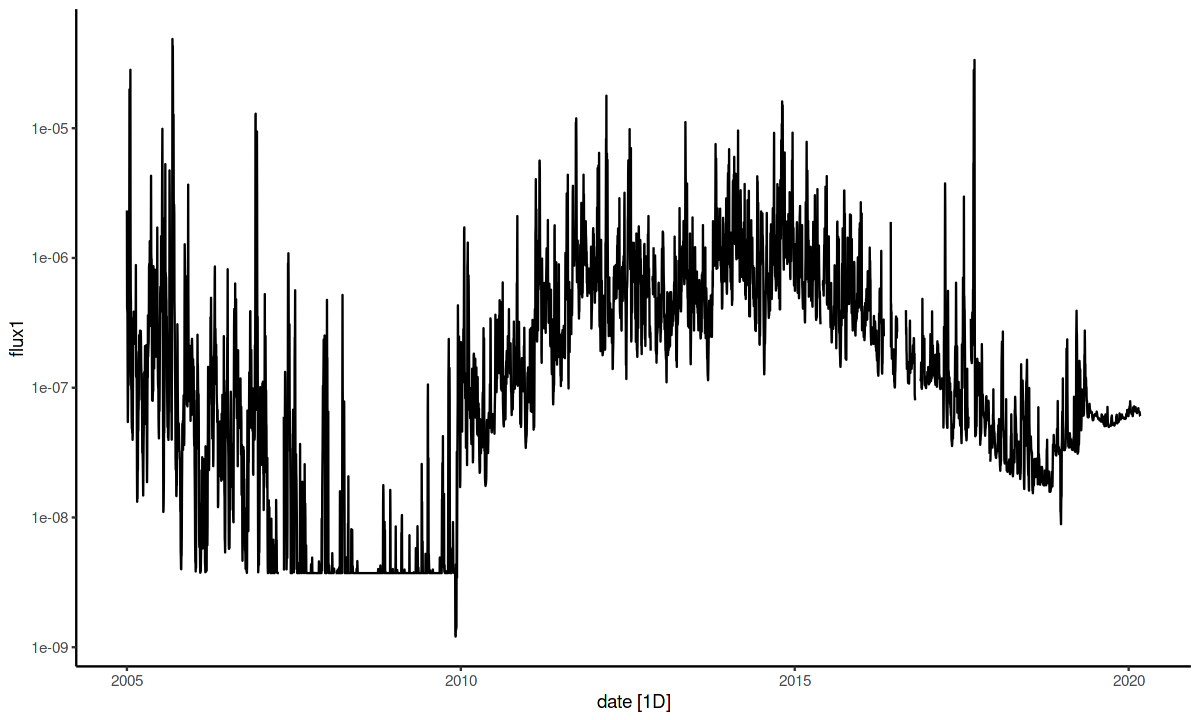

In [335]:
goes_daily_ts1 %>% autoplot(flux1) + scale_y_log10()

To make things a bit simpler I will combined the data from each satellite into a single daily average:

In [325]:
goes_daily_ts %>% index_by(date) %>% 
    summarize(across(flux1:flux2, mean)) -> goes_daily_ts1

goes_daily_ts1

date,flux1,flux2
<date>,<dbl>,<dbl>
2005-01-01,2.322763e-06,4.807203e-07
2005-01-02,4.118884e-07,1.955416e-08
2005-01-03,3.971638e-07,1.906986e-08
2005-01-04,3.723984e-07,2.424830e-08
2005-01-05,1.297508e-07,9.258739e-09
2005-01-06,5.442822e-08,3.840782e-09
2005-01-07,8.413164e-08,4.300927e-09
2005-01-08,1.472872e-07,4.712758e-09
2005-01-09,1.041388e-06,8.404922e-08


## Quiz 🤷  
Sometime in 2012 there was an [X-class solar flare](https://svs.gsfc.nasa.gov/10109/) event. When did it happen?

In [202]:
# 2012 solar flare?

## Quiz 🤷  
Solar activity is on an [approximately 11-year cycle](https://en.wikipedia.org/wiki/Solar_cycle). Can we see this in the X-Ray data? When do you think was the last solar maximum?

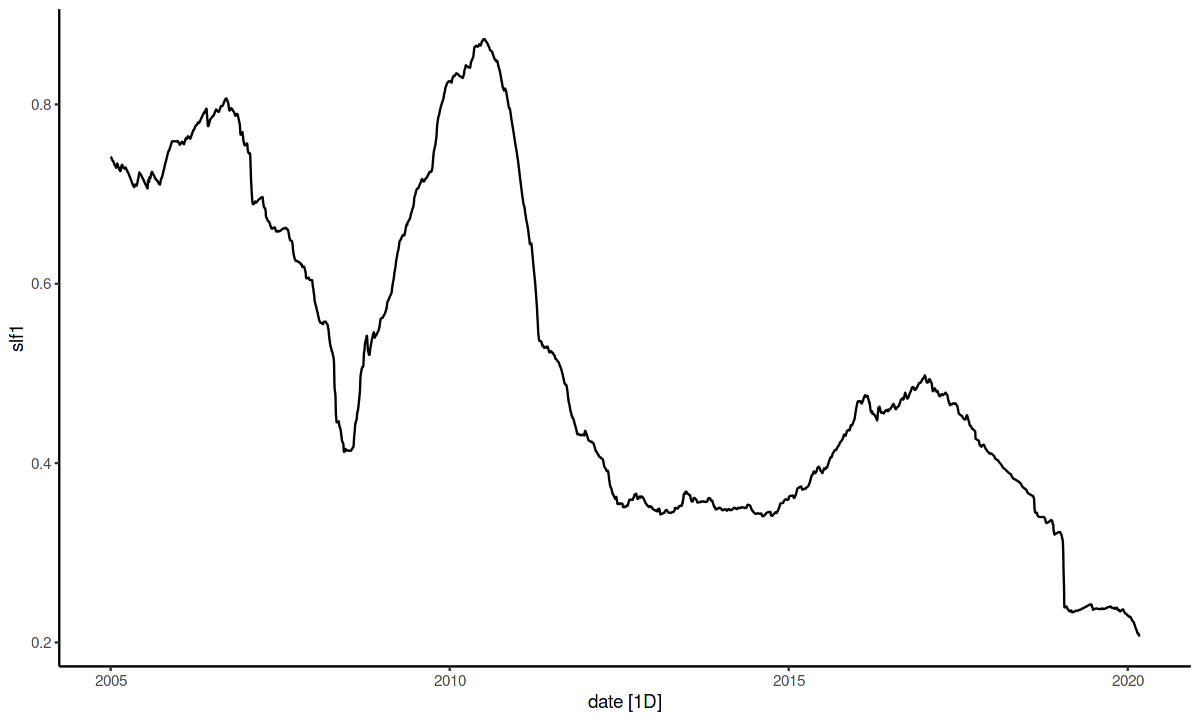

In [356]:
# solar activity

library(slider)

goes_daily_ts1 %>% mutate(slf1 = slide_dbl(log10(flux1), 
                                           \(x) sd(x, na.rm=T),
                                           .before=500, .after=500)) %>% 
    autoplot(slf1)

## Quiz 🤷
How does the *variance* in solar output compare for the current solar cycle ([S24](https://en.wikipedia.org/wiki/Solar_cycle_24_)) versus the last ([S23](https://en.wikipedia.org/wiki/Solar_cycle_23))? (Note: we only have partial data on S23 in this table.)

In [300]:
# variance in solar output

## Decomposing the solar cycle
Can we learn from data that the solar cycle is ~11 years long?

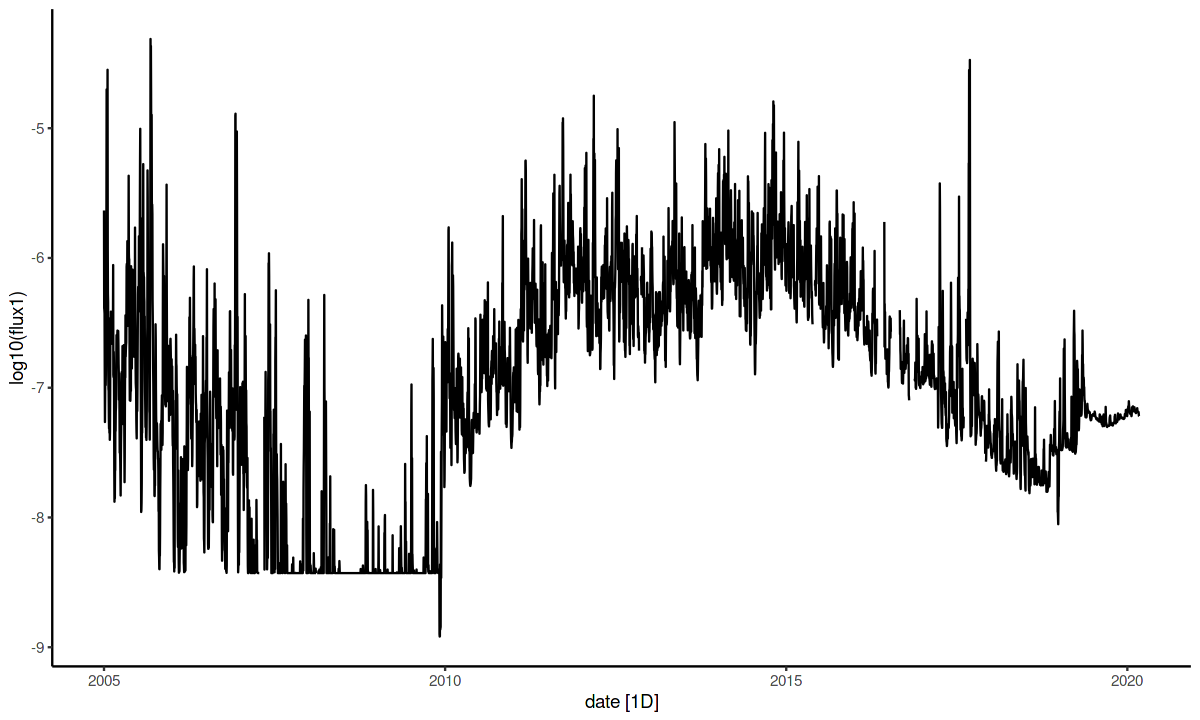

In [357]:
goes_daily_ts1 %>% autoplot(log10(flux1))

In [376]:
goes_daily_ts1 %>% 
    fill_gaps %>% 
    fill(flux1, flux2) %>% 
    filter(year(date) == 2005, month(date) == 11, day(date) == 16)

date,flux1,flux2
<date>,<dbl>,<dbl>
2005-11-16,6.764132e-07,4.619255e-08


In [377]:
smooth_goes <- function(k) {
    goes_daily_ts1 %>%
        fill_gaps %>% 
        fill(flux1) %>% 
        mutate(slf1 = slide_dbl(log10(flux1), \(x) mean(x, na.rm=T), .before=k, .after=k))
}

[1] 4015

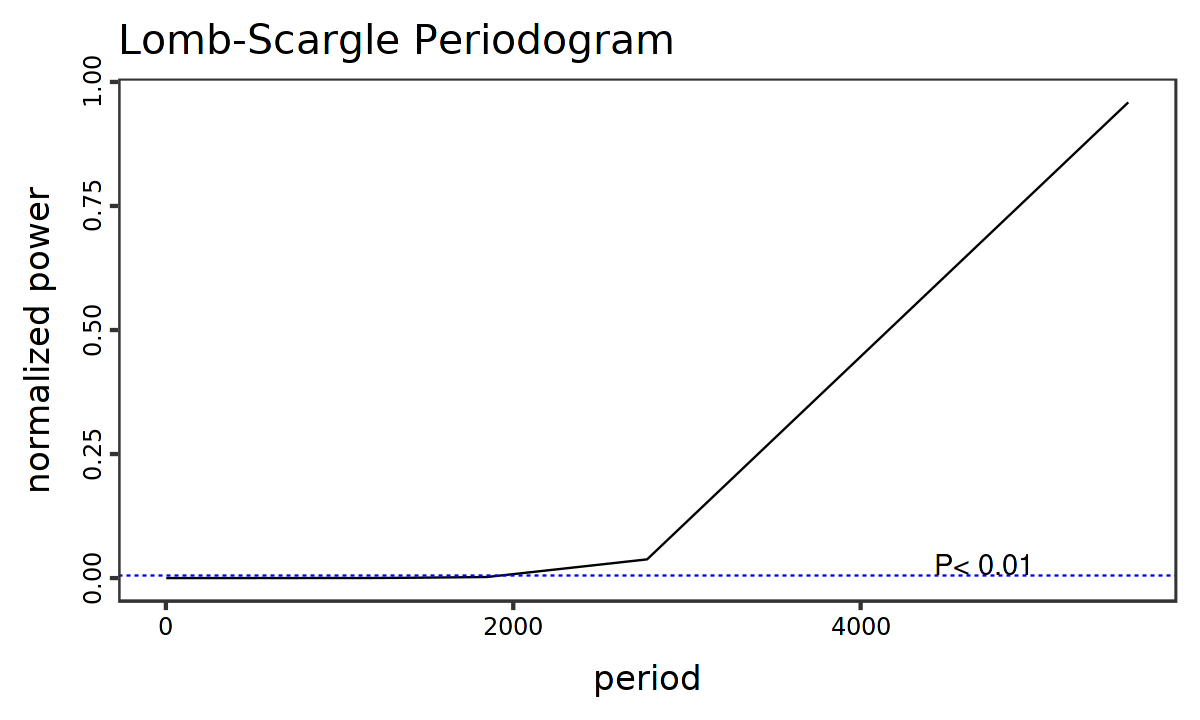

In [390]:
library(slider)
smooth_goes(1000) %>% pluck('slf1') %>% lsp(type = "period")

11 * 365

## Other types of decompositions

There are some well-known decompositions that analysts often apply to time-series data. We'll look at two:
- Classical decomposition
- STL

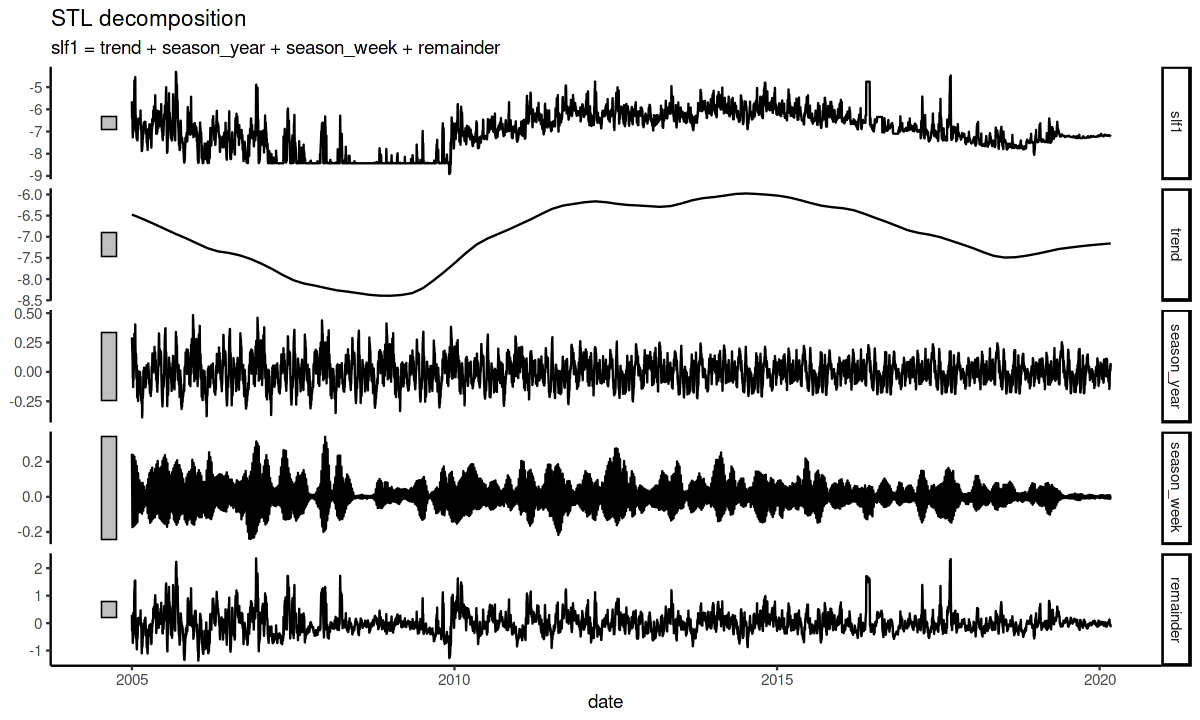

In [401]:
smooth_goes(0) %>% model(STL(slf1))  %>% 
    components %>% autoplot

## STL decomposition
STL decomposes the time series into *s*easonal and *t*rend (using a *L*OESS smoother).

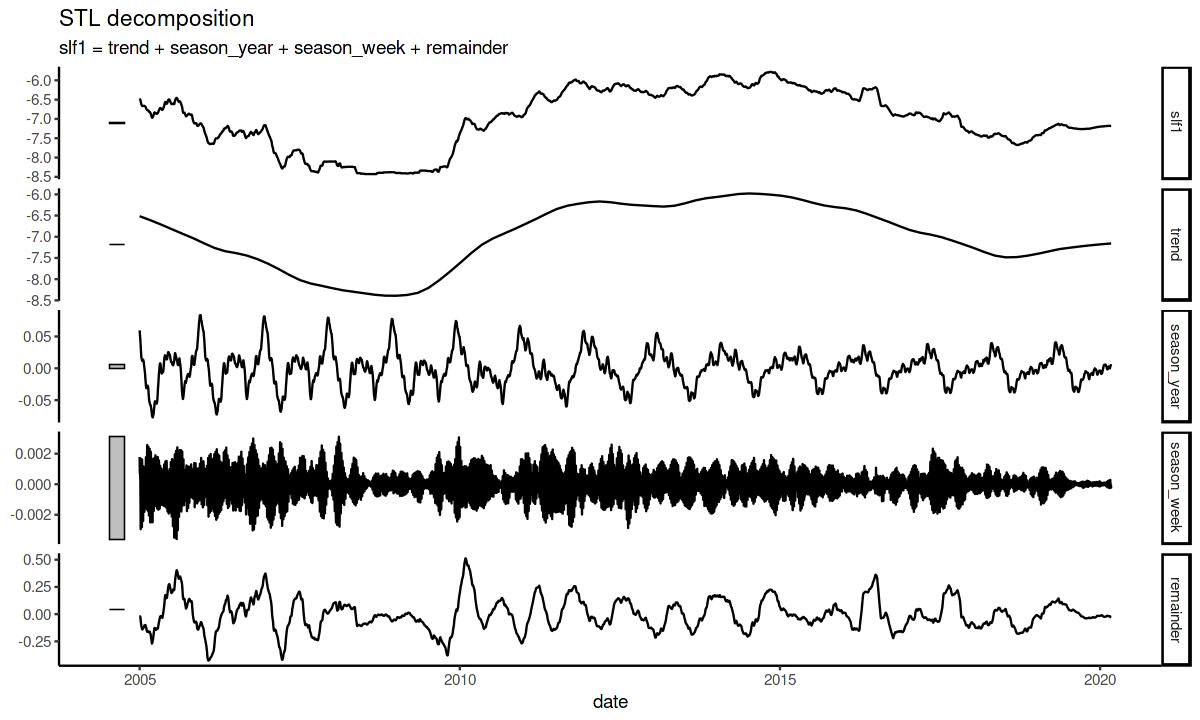

In [281]:
smooth_goes(50) %>% model(STL(slf1)) %>% 
    components %>% autoplot

## Autocorrelations
An autocorrelation plot shows the amount of correlation between a time series and its lags. It can be used to diagnose whether there are seasonal or trend components, since:
- When data have a trend, the correlations for small lags tend to be large and positive (why?) => AFC will have positive values that slowly decrease with lag length.
- When data are seasonal, the autocorrelations will be larger at multiples of the seasonal period.

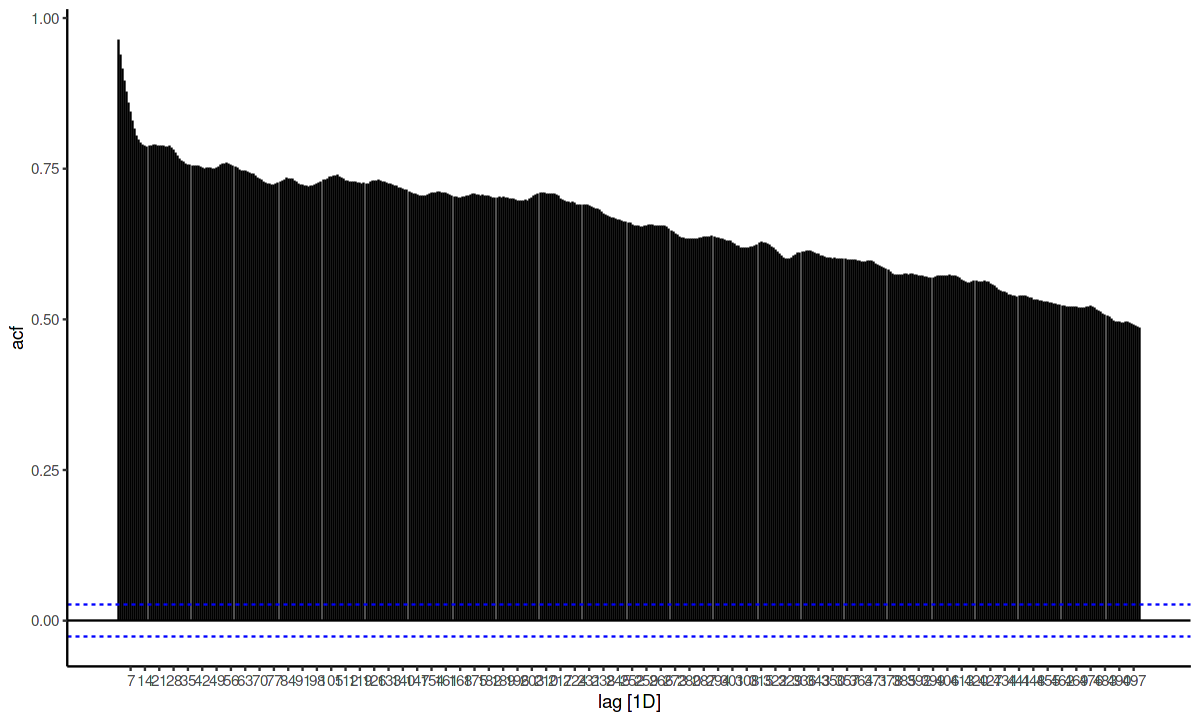

In [405]:
smooth_goes(0) %>% ACF(slf1, lag_max=500) %>% autoplot

## The Hurst coefficient
The [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) $H$ measures how much "memory" a time series has:

- $H\in[0.5,1]$ indicates a time series with long-term positive autocorrelation: a high value tends to be followed by another high value and that future excursions to more high values do occur. 
- $H\in[0,0.5]$ indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high
- A value of $H\approx 0.5$ indicates short-memory, with (absolute) autocorrelations decaying exponentially quickly to zero.

In [410]:
smooth_goes(1000) %>% features(flux1, coef_hurst)

coef_hurst
<dbl>
0.9384903


In [306]:
 %>% features(slf1, coef_hurst)

coef_hurst
<dbl>
0.99986
